<a href="https://colab.research.google.com/github/erezimm/ML-ML/blob/master/CNN_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main notebook, to be run on Google Colab

## Import dependencies and download dataset

In [9]:
!pip install dgl

import glob
import os
import shutil
from datetime import datetime

import astropy.io.ascii
import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

if not torch.cuda.is_available():
    raise Exception('Cuda unavailable, turn it on under Runtime>Change runtime type>GPU')
# device = torch.device('cude')

training_path = '/content/training_set'
validation_path = '/content/validation_set'
for path in (training_path, validation_path):
    if not os.path.isdir(path):
        os.makedirs(path)

!wget -O data.zip https://github.com/erezimm/ML-ML/raw/master/data.zip
!unzip -o -q data.zip -d /content/
data_path = '/content/data'
microlist = glob.glob(data_path+'/microlensedconst_*')
varlist = glob.glob(data_path+'/cleanvar_*')
for typelist in (microlist, varlist):
    for i, f in enumerate(typelist):
        dest = training_path if i<len(microlist)/2 else validation_path
        shutil.move(f, os.path.join(dest, os.path.basename(f)))

--2020-08-12 06:56:08--  https://github.com/erezimm/ML-ML/raw/master/data.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip [following]
--2020-08-12 06:56:08--  https://raw.githubusercontent.com/erezimm/ML-ML/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6541642 (6.2M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   6.24M  --.-KB/s    in 0.1s    

2020-08-12 06:56:08 (47.5 MB/s) - ‘data.zip’ saved [6541642/6541642]



## Create Datasets

In [10]:
import pandas as pd
from PIL import Image

path = training_path
dm_grid = [-8.0,-5.0,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.5,1,1.5,2,2.5,3,5,8]
dt_grid = [1/145,2/145,3/145,4/145,1/25,2/25,3/25,1.5,2.5,3.5,4.5,5.5,7,10,20,30,60,90,120,240,600,960,2000]

class CustomDataset(Dataset):
    def __init__(self, path,dm_grid,dt_grid):

      self.filelist = glob.glob(path+'/*')
      self.labels = self.get_labels()
      
    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        fname = self.filelist[idx]
        df = pd.read_csv(fname,delimiter=' ',names=['times', 'mags','errs']).sort_values('times').reindex()
        n = len(df)
        dts = pd.cut(np.diff(df['times'].to_numpy()),dt_grid)
        dms = pd.cut(np.diff(df['mags'].to_numpy()),dm_grid)
        grid = np.zeros([len(dms.categories),len(dts.categories)])
        for i in range(len(dts)):
            if dts[i] != None:
                dt_cat = np.where((dts[i] == dts.categories))[0]
                dm_cat = np.where((dms[i] == dms.categories))[0]
                grid[dm_cat,dt_cat]+=1
            else:
                n = n-1
        p = n*(n-1)/2
        grid = (((255*grid)/p)+0.999999).astype(int)
        label = self.labels[idx]
        return torch.FloatTensor(grid).unsqueeze(0),label

    def get_labels(self):
        labels = []
        for fname in self.filelist:
            filebasename = os.path.basename(fname)
            if filebasename.startswith('cleanvar'):
                labels.append(0)
            elif filebasename.startswith('microlensedconst'):
                labels.append(1)
            else:
                raise Exception('Filename ' + fname + ' not clean_* or microlensed_*')
        return torch.LongTensor(labels)

In [11]:
train_ds = CustomDataset(training_path,dm_grid,dt_grid)
valid_ds = CustomDataset(validation_path,dm_grid,dt_grid)

torch.Size([1, 22, 22])


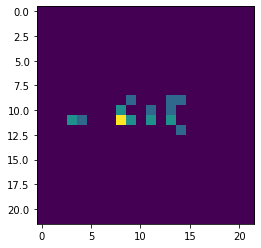

In [12]:
import matplotlib.pyplot as plt

x,y = train_ds[100]
print(x.shape)
plt.imshow(x[0])

## The Newtwork

In [30]:
class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1,64,3),nn.LeakyReLU(),nn.MaxPool2d(2,stride=2),nn.Dropout(0.1))
        self.conv2 = nn.Sequential(nn.Conv2d(64,128, 5),nn.LeakyReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(128,256, 5),nn.LeakyReLU())
        self.linear = nn.Sequential(nn.Linear(1024,512),nn.Dropout(0.3),nn.Linear(512,256),nn.Linear(256,2),nn.Softmax())
        
    def forward(self, x):
        out = self.conv1(x)
        # print(out.s3hape)    
        out = self.conv2(out)
        # print(out.shape)
        out = self.conv3(out)
        # print(out.shape)
        out = torch.flatten(out,1)
        # print(out.shape)
        out = self.linear(out)
        return out

In [31]:
net = ImageClassifier()
if torch.cuda.is_available():
   net = net.cuda()

## Train

In [34]:
data_loader = DataLoader(train_ds, batch_size=1000)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.0002)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.1)
valid_dl = DataLoader(valid_ds, batch_size=1000)

In [35]:
n_epochs = 50
losses = []
valid_losses = []
for epoch in tqdm( range(n_epochs)):
    epoch_loss = []
    epoch_valid_loss = []
    net.train()
    for x,y in data_loader:
        if torch.cuda.is_available():
            x = x.to(torch.device('cuda'))
            y = y.cuda()
        pred = net(x)
        loss = loss_func(pred,y)
        epoch_loss.append(loss.cpu().data.numpy())

        loss.backward()
        opt.step()
        opt.zero_grad()

    net.eval()
    for x,y in valid_dl:
        if torch.cuda.is_available():
            x = x.to(torch.device('cuda'))
            y = y.cuda()
        pred = net(x)
        valid_loss = loss_func(pred,y)
        epoch_valid_loss.append(loss.cpu().data.numpy())

    losses.append(np.mean(epoch_loss))
    valid_losses.append(np.mean(epoch_valid_loss))

    print(epoch,"training loss is ",np.mean(epoch_loss),"validation loss is ",np.mean(epoch_valid_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 training loss is  0.6734761 validation loss is  0.65528
1 training loss is  0.6344211 validation loss is  0.64213395
2 training loss is  0.62757826 validation loss is  0.6218972
3 training loss is  0.6234039 validation loss is  0.6180375
4 training loss is  0.6061055 validation loss is  0.5977911
5 training loss is  0.5967316 validation loss is  0.5840461
6 training loss is  0.5896205 validation loss is  0.5765843
7 training loss is  0.5765554 validation loss is  0.5658507
8 training loss is  0.5652857 validation loss is  0.5476843
9 training loss is  0.55731297 validation loss is  0.5465241
10 training loss is  0.5482223 validation loss is  0.5332413
11 training loss is  0.538746 validation loss is  0.5250792
12 training loss is  0.5312268 validation loss is  0.5187498
13 training loss is  0.52446675 validation loss is  0.5088616
14 training loss is  0.52149385 validation loss is  0.5120432
15 training loss is  0.51961464 validation loss is  0.5026453
16 training loss is  0.51052827

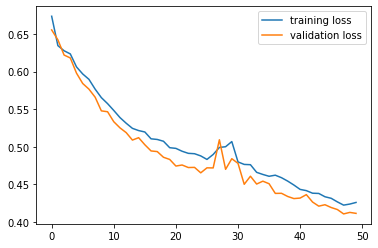

In [36]:
plt.plot(losses,label='training loss')
plt.plot(valid_losses,label='validation loss')
plt.legend()
plt.show()

In [24]:
torch.save(net.state_dict(), 'model_50.pt')

In [37]:
def evaluate(net, validation_ds):
    test_data_loader = DataLoader(validation_ds, batch_size=100)

    net.cpu()
    net.eval()

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0

    for i, (x,y) in enumerate(test_data_loader):
            y = y.data.numpy()
            prediction = net(x).cpu().data.numpy()

            pred = (prediction[:,1]>prediction[:,0]/1)

            total_positives+=len(np.where( y==1 )[0])
            total_negatives+=len(np.where( y==0 )[0])
            
            true_positive+= len(np.where( (pred==y) & (y==1) )[0])
            false_positive+= len(np.where( (pred!=y) & (y==0) )[0])
                    
    print('Probability of detection:', true_positive/total_positives)  # probability of recognizing a microlensing when you see it
    print('Probability of false alarm:', false_positive/total_negatives)  # probability for misclassification of a variable star as microlensing

In [38]:
evaluate(net,valid_ds)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Probability of detection: 0.8096
Probability of false alarm: 0.184


In [ ]:
net = ImageClassifier()
net.load_state_dict(torch.load('model_1.pt'))
net.eval()